In [1]:
import fl_funcs
from fl_funcs import exponential
from fl_funcs import exponential_neg
import numpy as np

In [2]:
year = 2014
mo = 4
day = 4
sthr = 3
stmin = 43
arnum = 12026
xclnum = 3.6
xcl = 'C'
flnum = 1924
instrument = 'n5'
daystr = '04'
mostr = 'apr'
mostrcap = 'Apr'
yearstr = '2014'
imp = -4.73

bestflarefile = '/Users/coletamburri/Desktop/imp_dev/all_and_best_Oct_2022.mat'

In [3]:
print("Loading the data...")

sav_data_aia, sav_data, best304, start304, peak304, end304, eventindices,\
    times304, curves304, aia_cumul8, aia_step8, last_cumul8, hmi_dat,\
    last_mask = fl_funcs.load_variables(bestflarefile, year, mo, day, sthr,
                                        stmin, arnum,
                                        xclnum, xcl)

X, Y, conv_f, xarr_Mm, yarr_Mm = fl_funcs.conv_facts()

print("Data loaded! Now just some masking and spur removal.")

hmi_cumul_mask1, hmi_step_mask1, hmi_pos_mask_c, hmi_neg_mask_c \
    = fl_funcs.pos_neg_masking(aia_cumul8, aia_step8, hmi_dat, last_mask)

neg_rem, pos_rem = fl_funcs.spur_removal_sep(hmi_neg_mask_c, hmi_pos_mask_c,
                                             pos_crit=2, neg_crit=3,
                                             ilo2=380)

print("Convolving the HMI images and making the PIL mask.")

hmi_con_pos_c, hmi_con_neg_c, pil_mask_c = fl_funcs.gauss_conv(pos_rem,
                                                               neg_rem,
                                                               sigma=5)

pil_mask_c, ivs, dvs, hmik = fl_funcs.pil_gen(
    pil_mask_c, hmi_dat, threshperc=0.01)

print("Separation values determination.")

aia8_pos_step, aia8_neg_step = fl_funcs.mask_sep(aia_step8, hmi_dat)

pos_rem0, neg_rem0 = fl_funcs.spur_removal_sep2(
    aia8_pos_step, aia8_neg_step, klo2=200)

distpos_med, distpos_mean, distneg_med, distpos_mean \
    = fl_funcs.separation(aia_step8, ivs, dvs, pos_rem0, neg_rem0)

for i in range(1, len(distpos_med)):
    if distpos_med[i] > 50:
        distpos_med[i] = distpos_med[i-1]

print("Elongation values determination.")

aia8_pos_2, aia8_neg_2 = fl_funcs.mask_elon(aia_cumul8, hmi_dat)

neg_rem1, pos_rem1 = fl_funcs.spur_removal_elon(aia8_pos_2, aia8_neg_2)

ivs_lim, dvs_lim, med_x, med_y = fl_funcs.lim_pil(ivs, dvs)

Loading the data...
Data loaded! Now just some masking and spur removal.
Convolving the HMI images and making the PIL mask.
Separation values determination.
Elongation values determination.


In [4]:
ylim0_neg = 325
ylim1_neg = 450
ylim0_pos = int(round(med_y)-100)
ylim1_pos = int(round(med_y)+100)
xlim0_neg = 300
xlim1_neg = 500
xlim0_pos = 350
xlim1_pos = 500

aia_pos_rem, aia_neg_rem = fl_funcs.rib_lim_elon(aia8_pos_2, aia8_neg_2,
                                                 pos_rem1, neg_rem1, med_x,
                                                 med_y, ylim0_pos, ylim1_pos,
                                                 ylim0_neg, ylim1_neg,
                                                 xlim0_pos, xlim1_pos,
                                                 xlim0_neg, xlim1_neg)


lr_coord_neg, lr_coord_pos = fl_funcs.find_rib_coordinates(aia_pos_rem,
                                                           aia_neg_rem)


ivs_sort, dvs_sort, sortedpil = fl_funcs.sort_pil(ivs_lim, dvs_lim)

pil_right_near_pos, pil_left_near_pos, pil_right_near_neg, pil_left_near_neg \
    = fl_funcs.elon_dist_arrays(lr_coord_pos, lr_coord_neg, ivs_lim, dvs_lim,
                                ivs_sort, dvs_sort)


lens_pos, lens_neg = fl_funcs.elongation(pil_right_near_pos, pil_left_near_pos,
                                         pil_right_near_neg, pil_left_near_neg,
                                         sortedpil)

dist_pos = distpos_med
dist_neg = distneg_med

Converting separation and elongation to Mm.
Loading parameters for 304 and 1600 Angstrom light curves.
Determining the regions of separation and elongation.
Plotting ribbon masks.
Plotting convolution masks.
Plotting PIL with representative polynomial.
Plotting ribbon separation.


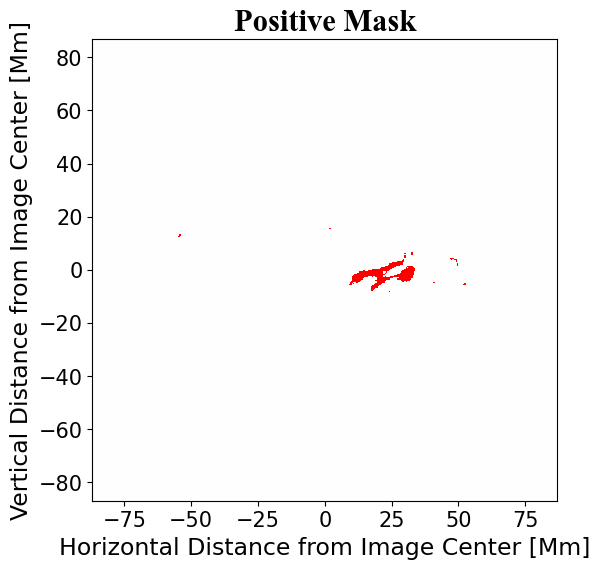

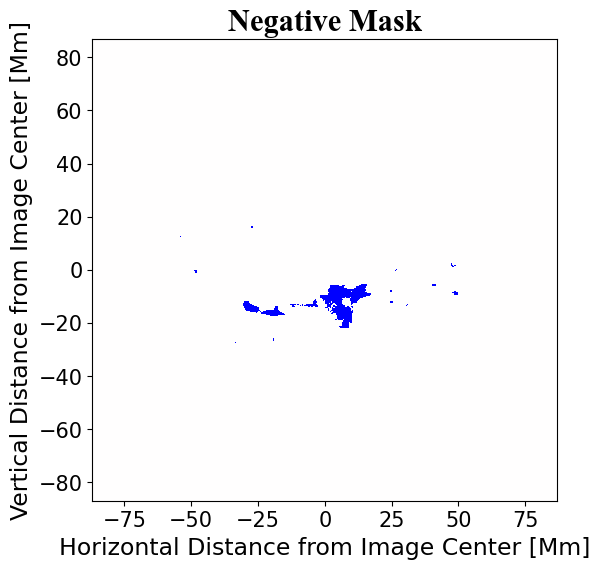

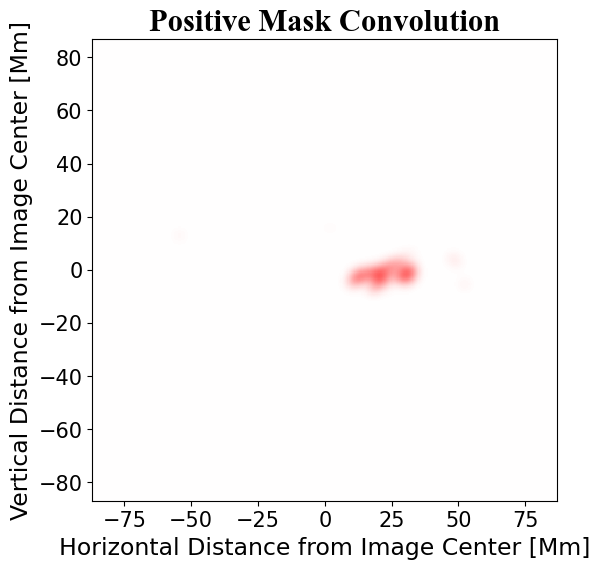

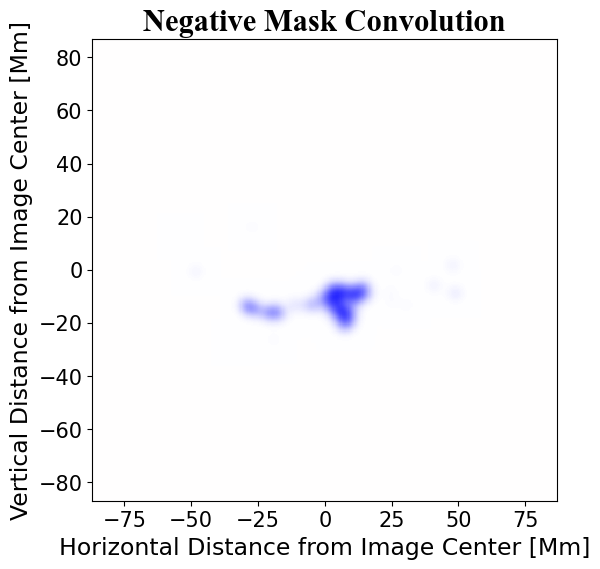

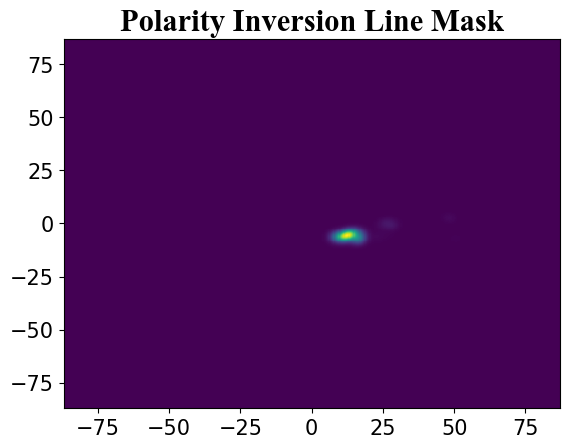

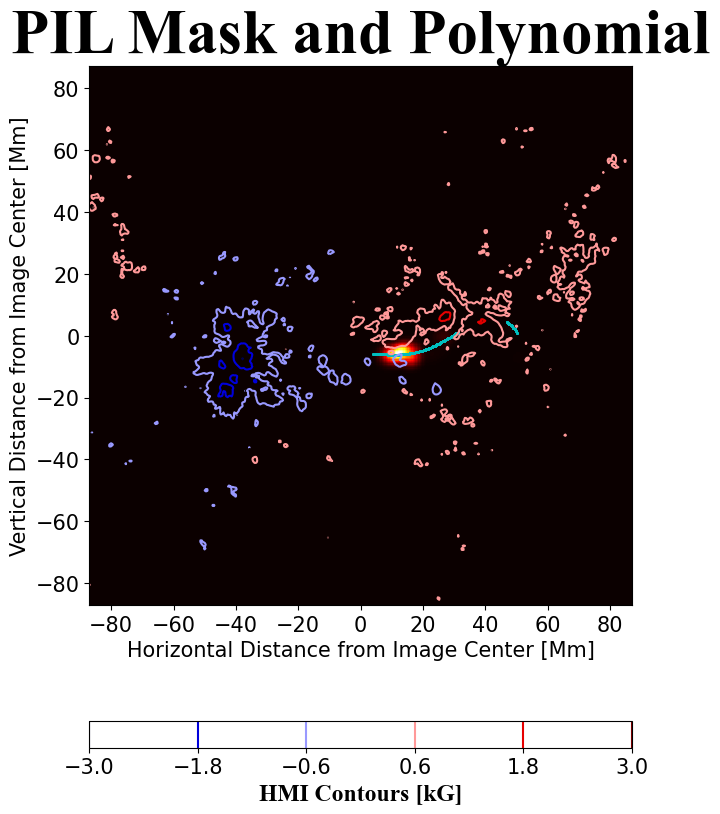

In [5]:
print("Converting separation and elongation to Mm.")

lens_pos_Mm, lens_neg_Mm, distpos_Mm, distneg_Mm, dneg_len, dpos_len, \
    dneg_dist, dpos_dist = fl_funcs.convert_to_Mm(lens_pos, dist_pos, lens_neg,
                                                  dist_neg, conv_f)

print("Loading parameters for 304 and 1600 Angstrom light curves.")

startin, peakin, endin, times, s304, e304, filter_304, med304, std304, \
    timelab, aiadat, nt, dn1600, time304, times1600 \
    = fl_funcs.prep_304_1600_parameters(sav_data_aia, sav_data, eventindices,
                                        flnum, start304, peak304, end304,
                                        times304, curves304)

posrib, negrib, pos1600, neg1600 = fl_funcs.img_mask(aia8_pos_step,
                                                     aia8_neg_step, aiadat, nt)

print("Determining the regions of separation and elongation.")


elonperiod_start_pos, elonperiod_end_pos, elonperiod_start_neg, \
    elonperiod_end_neg = fl_funcs.elon_periods(dpos_len, dneg_len, m_min=0,
                                               neg_crit=0)

sepperiod_start_pos, sepperiod_end_pos, sepperiod_start_neg, \
    sepperiod_end_neg = fl_funcs.sep_periods(dpos_dist, dneg_dist, start=1)

dt1600, dt304 = fl_funcs.prep_times(dn1600, time304)

print("Plotting ribbon masks.")

fl_funcs.mask_plotting(X, Y, pos_rem, neg_rem, xarr_Mm, yarr_Mm, flnum)

print("Plotting convolution masks.")

fl_funcs.convolution_mask_plotting(X, Y, hmi_con_pos_c, hmi_con_neg_c,
                                   pil_mask_c, xarr_Mm, yarr_Mm, flnum,
                                   xlim=[200, 600], ylim=[200, 600])

print("Plotting PIL with representative polynomial.")

fl_funcs.pil_poly_plot(X, Y, pil_mask_c, hmi_dat, ivs, dvs, conv_f, xarr_Mm,
                       yarr_Mm, flnum)

print("Plotting ribbon separation.")

Plotting ribbon elongation.
Plotting Elongation with Periods
Plotting Separation with Periods
Processing data for reconnection flux model.
Load fluxes and pixel counts.
The same, for instantaneous flux.
Reconnection Rate Determination, Plotting.
Exponential curve fitting for the fluxes.
Exponential curve plot.


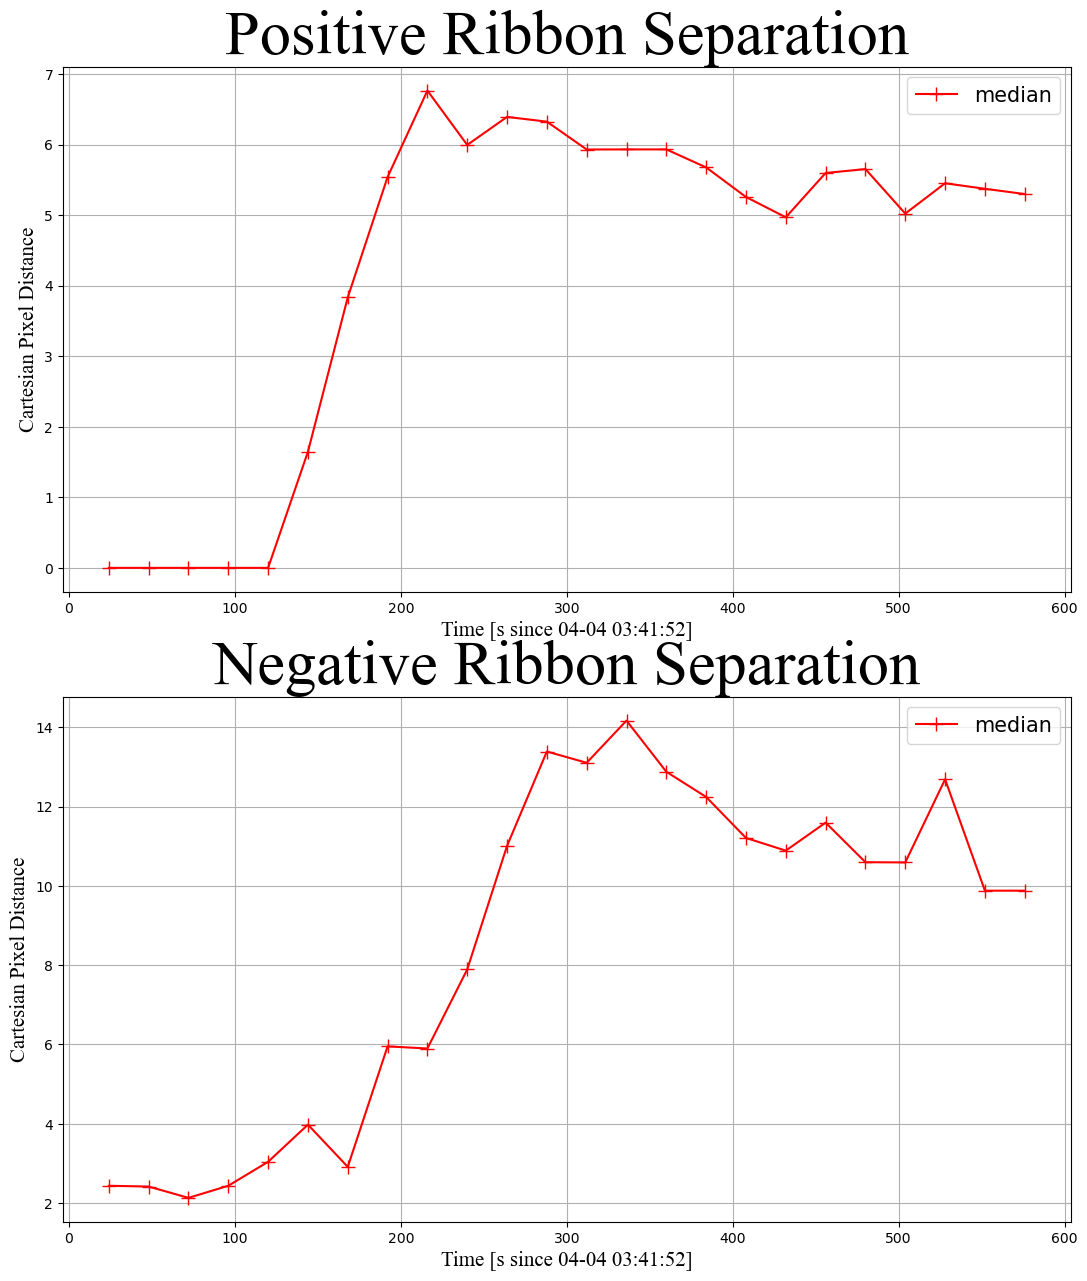

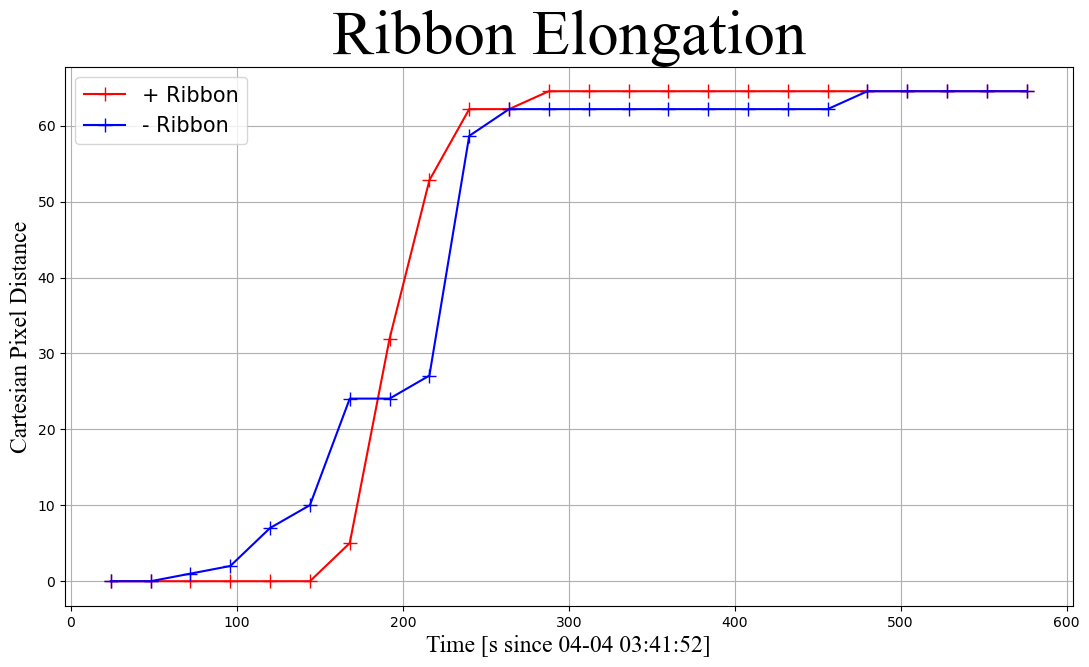

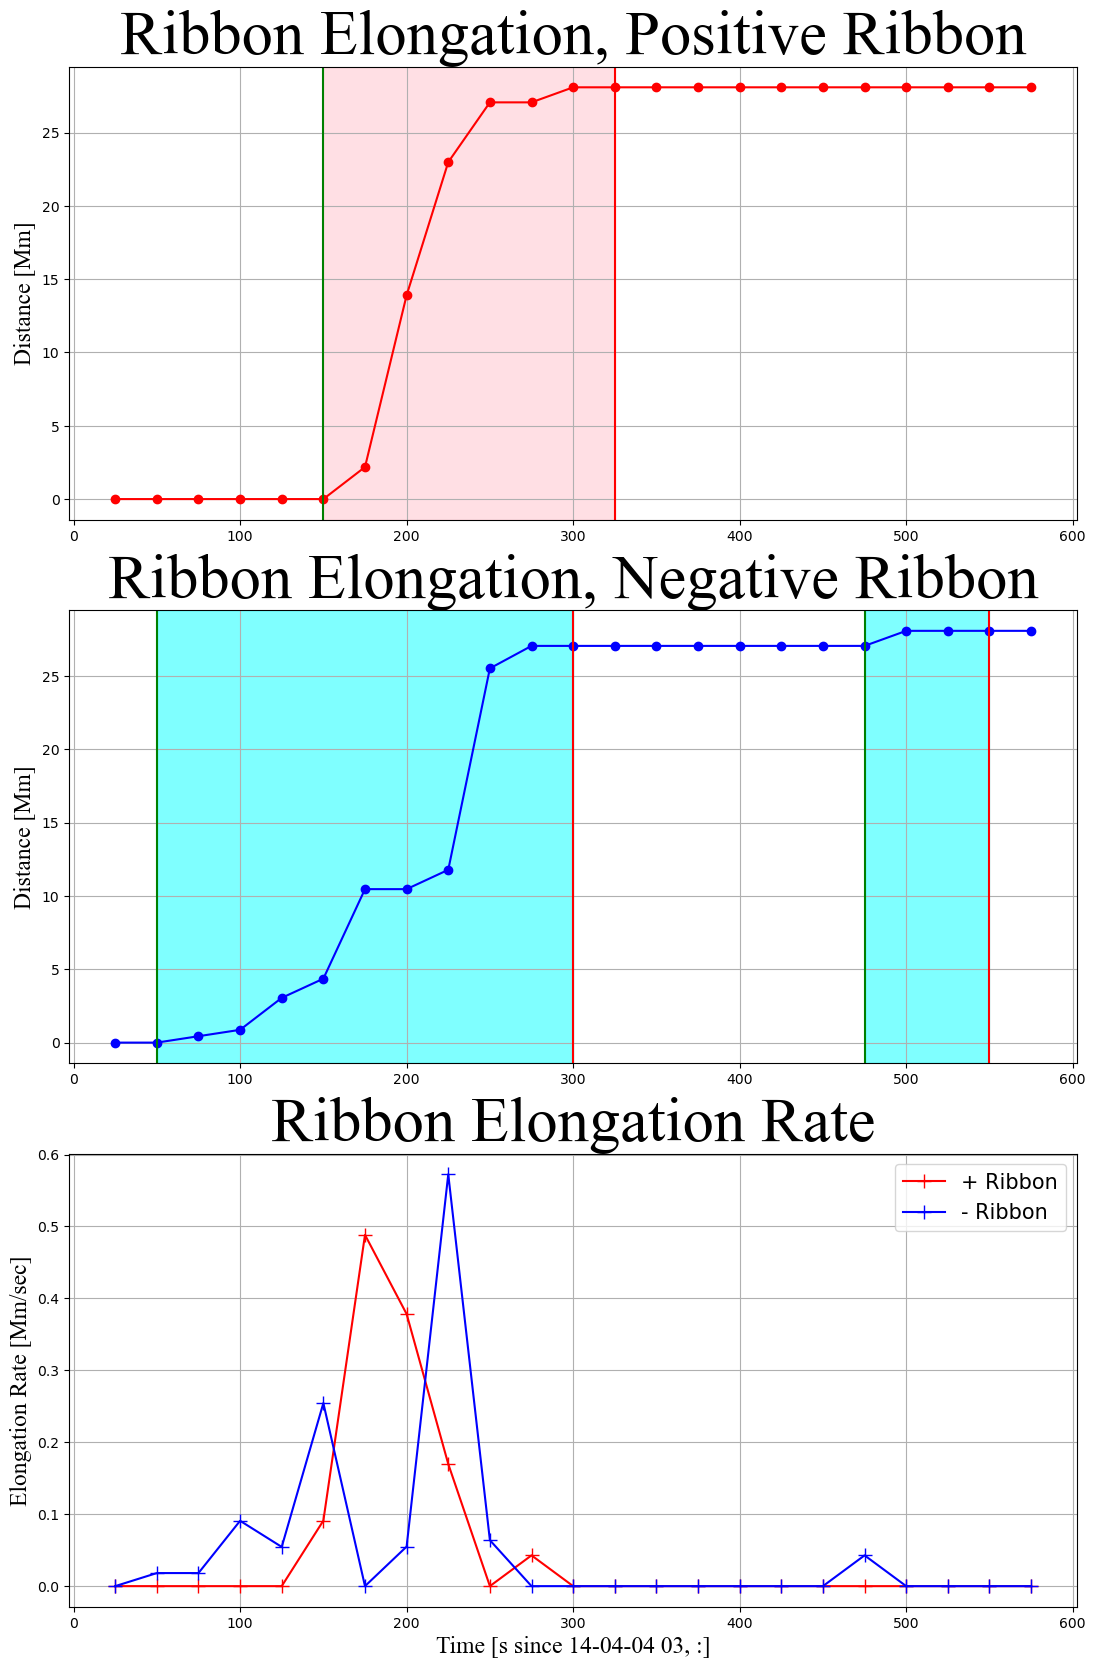

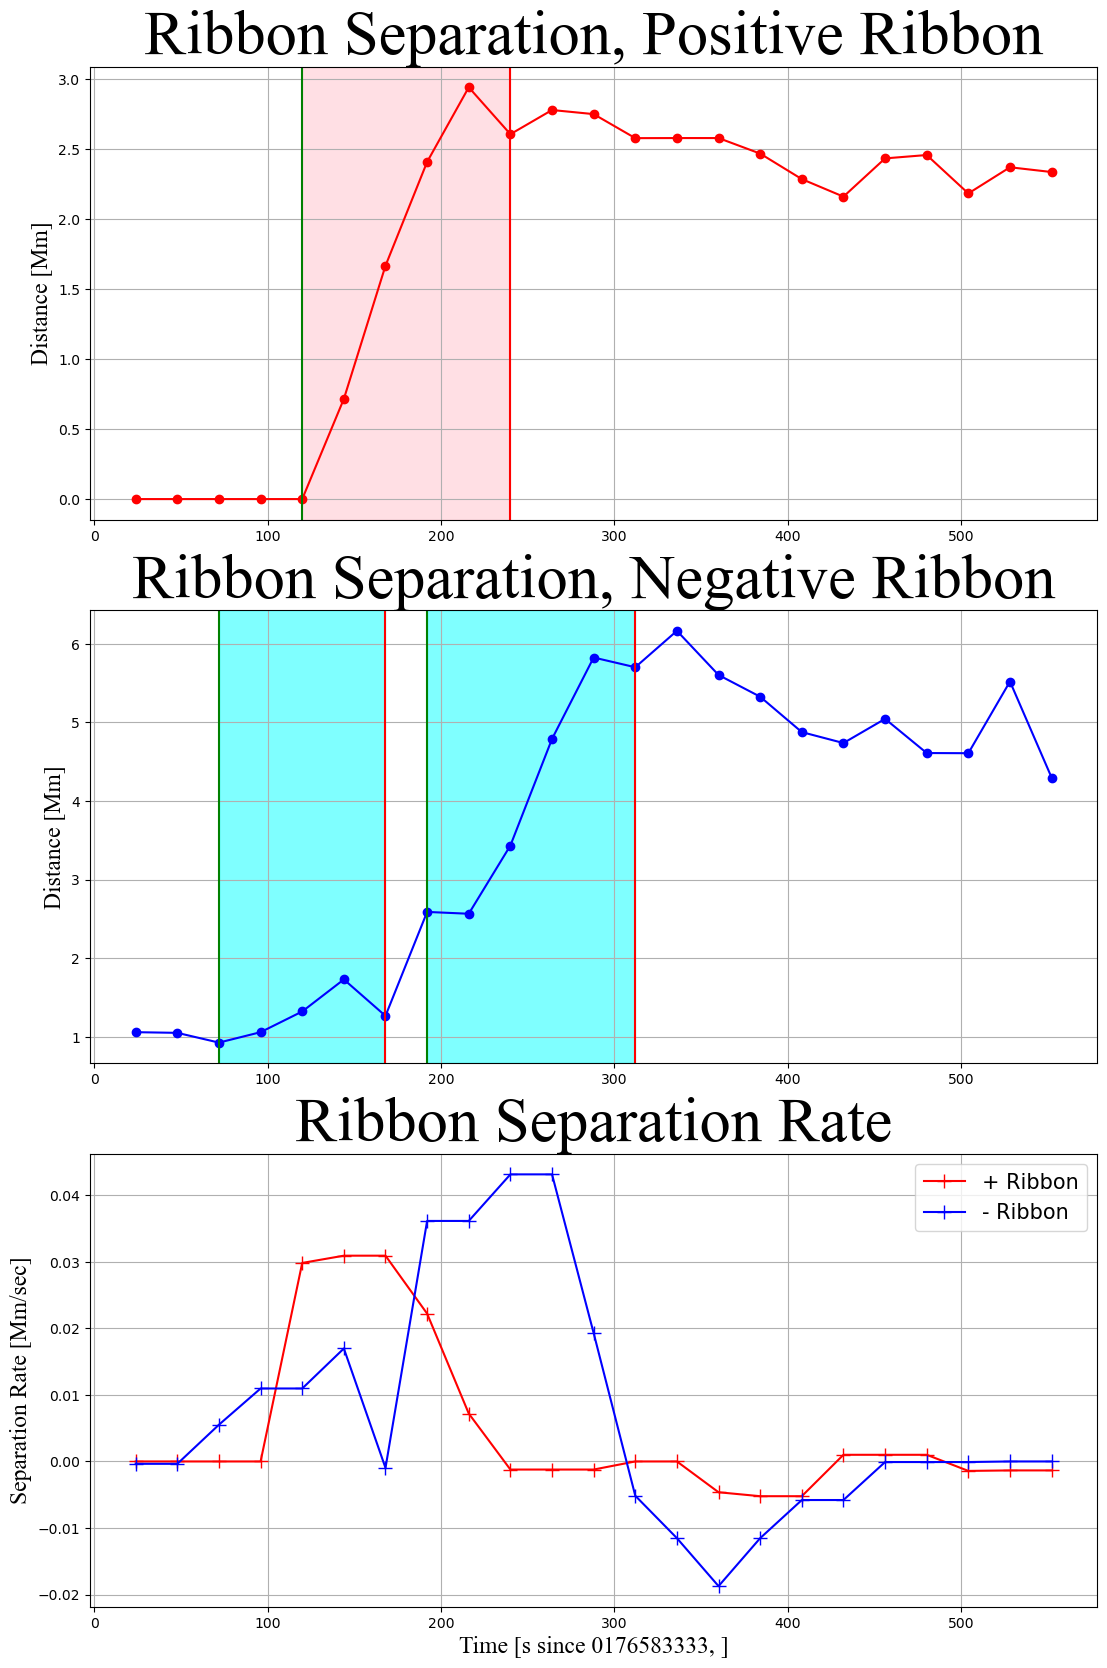

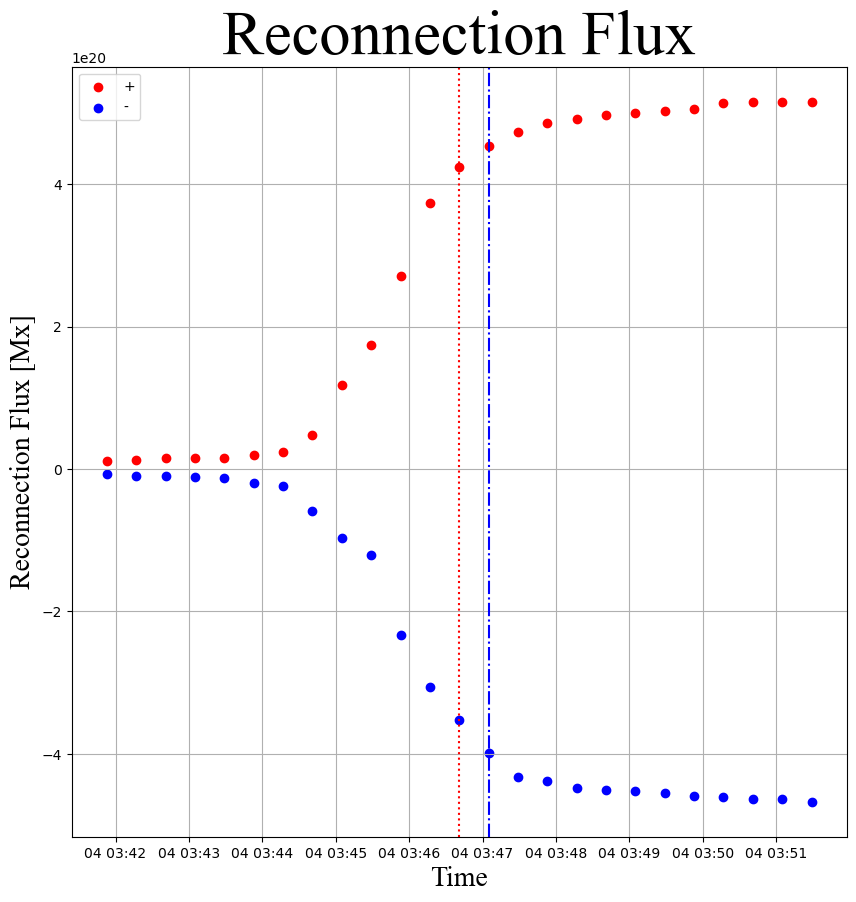

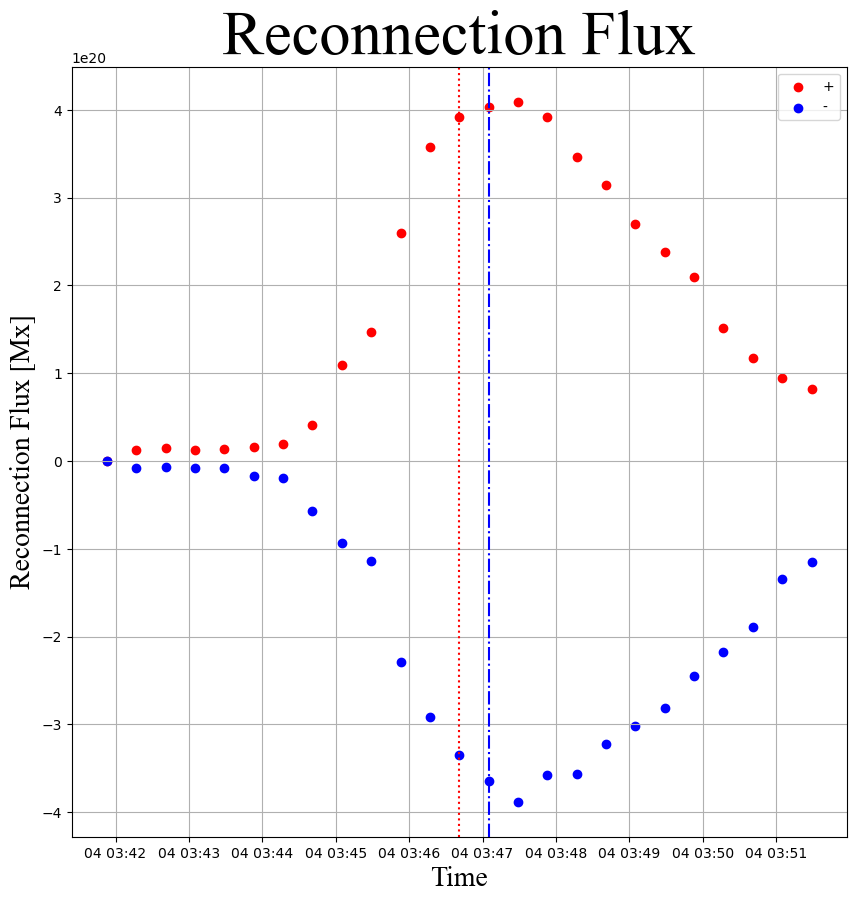

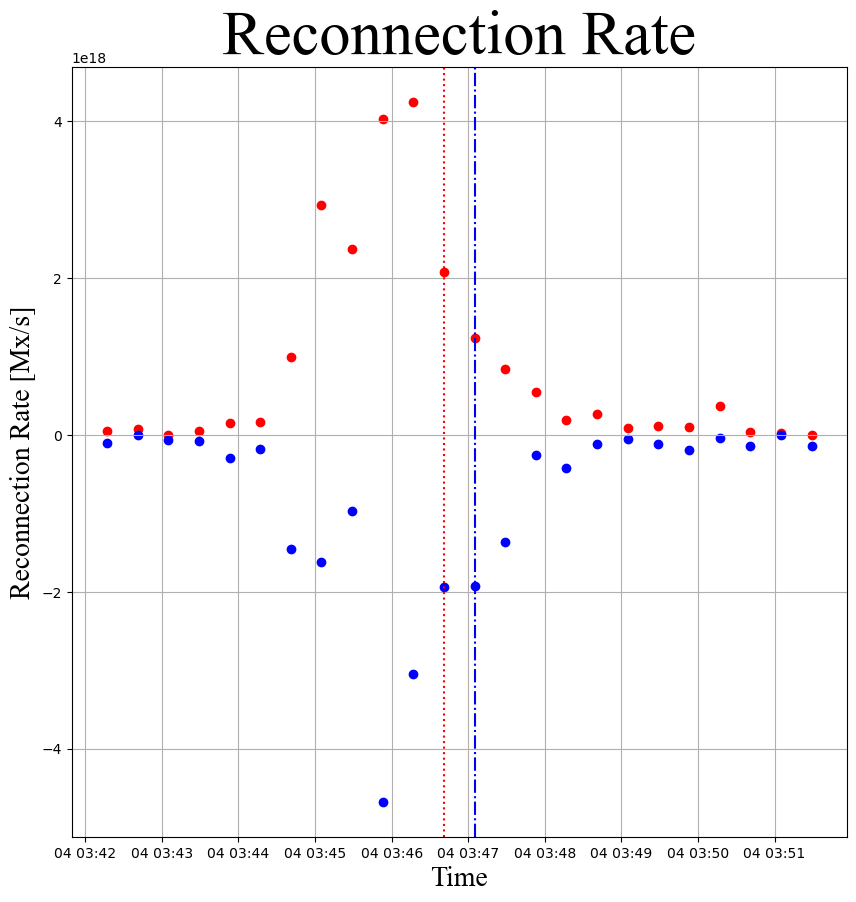

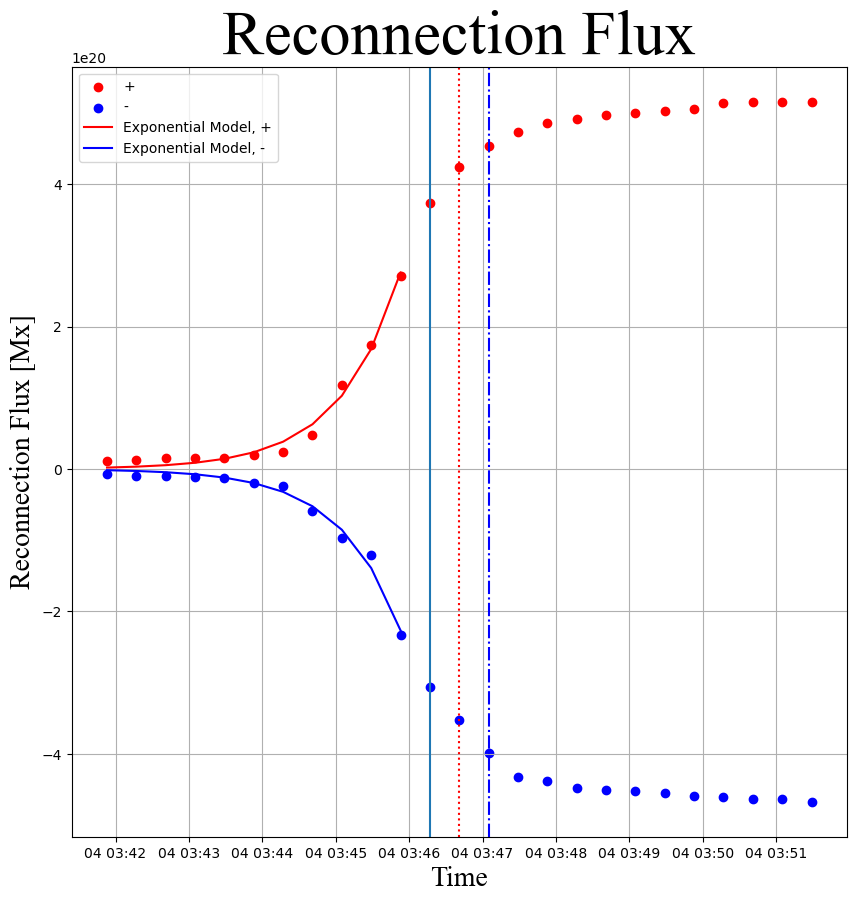

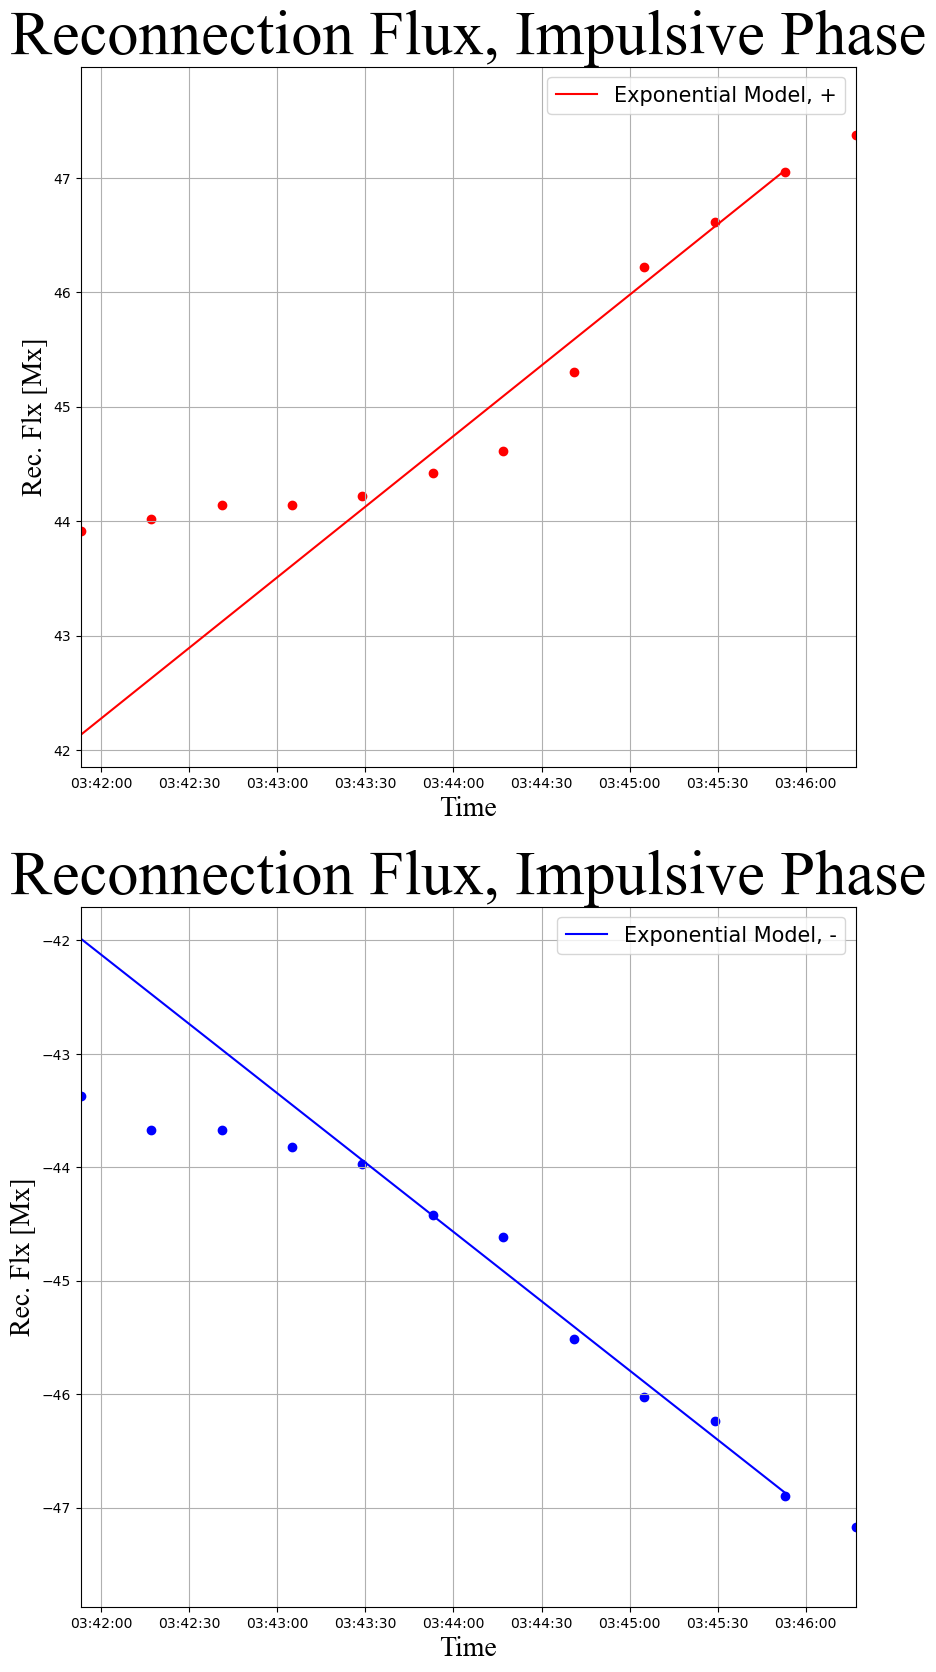

In [6]:
pltstrt = 1

fl_funcs.ribbon_sep_plot(dist_pos, dist_neg, times, flnum, pltstrt, dt1600)

print("Plotting ribbon elongation.")

pltstrt = 1

fl_funcs.ribbon_elon_plot(lens_pos, lens_neg, times, pltstrt, flnum, dt1600)

print("Plotting Elongation with Periods")
indstrt = 1
fl_funcs.elon_period_plot(dpos_len, dneg_len, times, times1600, lens_pos_Mm,
                          lens_neg_Mm, flnum, elonperiod_start_neg,
                          elonperiod_start_pos, elonperiod_end_neg,
                          elonperiod_end_pos, indstart=indstrt)

print("Plotting Separation with Periods")

indstrt = 1
fl_funcs.sep_period_plot(dpos_dist, dneg_dist, times, distpos_Mm, distneg_Mm,
                         flnum, sepperiod_start_pos, sepperiod_end_pos,
                         sepperiod_start_neg, sepperiod_end_neg,
                         indstrt=indstrt)

print("Processing data for reconnection flux model.")

hmi, aia8_pos, aia8_neg, aia8_inst_pos, aia8_inst_neg, peak_pos, \
    peak_neg = fl_funcs.flux_rec_mod_process(
        sav_data, dt1600, pos1600, neg1600)

print("Load fluxes and pixel counts.")

rec_flux_pos, rec_flux_neg, pos_pix, neg_pix, pos_area_pix, neg_area_pix, ds2,\
    pos_area, neg_area = fl_funcs.cumul_flux_process(aia8_pos, aia8_neg,
                                                     conv_f, flnum, peak_pos,
                                                     peak_neg, hmi, dt1600)

print("The same, for instantaneous flux.")

rec_flux_pos_inst, rec_flux_neg_inst, pos_pix_inst, neg_pix_inst, \
    ds2 = fl_funcs.inst_flux_process(aia8_inst_pos, aia8_inst_neg, flnum,
                                     conv_f, hmi, dt1600, peak_pos, peak_neg)

print("Reconnection Rate Determination, Plotting.")

rec_rate_pos, rec_rate_neg = fl_funcs.rec_rate(rec_flux_pos, rec_flux_neg,
                                               dn1600, dt1600, peak_pos,
                                               peak_neg, flnum)

exp_ind = np.argmax(rec_rate_pos)+1
exp_ind_area = np.argmax(rec_rate_pos)+1

print("Exponential curve fitting for the fluxes.")

poptposflx, pcovposflx, poptnegflx, pcovnegflx, \
    poptpos, poptneg, pcovpos, pcovneg, rise_pos_flx, \
    rise_neg_flx = fl_funcs.exp_curve_fit(exp_ind, exp_ind_area, pos_pix,
                                          neg_pix, exponential,
                                          exponential_neg, pos_area,
                                          neg_area)

print("Exponential curve plot.")

fl_funcs.exp_curve_plt(dt1600, rec_flux_pos, rec_flux_neg, rise_pos_flx,
                       rise_neg_flx, peak_pos, peak_neg, exp_ind, ds2,
                       exponential, exponential_neg, poptposflx, poptnegflx,
                       flnum)

In [7]:
print("Begin shear determination.")

# Establish limits for ribbons corresponding to shear code.
negylow = ylim0_neg
negyhi = ylim1_neg
negxlow = xlim0_neg
negxhi = xlim1_neg

posylow = ylim0_pos
posyhi = ylim1_pos
posxlow = xlim0_pos
posxhi = xlim1_pos

# Isolate ribbons appropriately for shear analysis
aia_neg_rem_shear, aia_pos_rem_shear = fl_funcs.\
    shear_ribbon_isolation(aia8_neg_step, aia8_pos_step, med_x, med_y,
                           negylow=negylow, negyhi=negyhi, posylow=posylow,
                           posyhi=posyhi, negxlow=negxlow, negxhi=negxhi,
                           posxlow=posxlow, posxhi=posxhi, flag=1)

# Left and right coordinates of positive and negative ribbons
lr_coord_neg_shear, lr_coord_pos_shear = \
    fl_funcs.leftrightshear(aia_pos_rem_shear, aia_neg_rem_shear)

# PIL pixels closest to the left and right coordinates of positive and negative
# ribbons
pil_right_near_pos_shear, pil_left_near_pos_shear, pil_right_near_neg_shear,\
    pil_left_near_neg_shear = fl_funcs.sheardists(lr_coord_pos_shear,
                                                  lr_coord_neg_shear,
                                                  ivs_sort, dvs_sort)

# Guide field to the right and left edges of ribbons
guide = fl_funcs.guidefieldlen_alt(pil_right_near_pos_shear,
                                   pil_left_near_pos_shear,
                                   pil_right_near_neg_shear,
                                   pil_left_near_neg_shear,
                                   sortedpil, fl_funcs.curve_length, 'posleft')

Begin shear determination.


In [129]:
importlib.reload(fl_funcs)

<module 'fl_funcs' from '/Users/coletamburri/Desktop/flare_imp_study/fl_funcs.py'>

/Users/coletamburri/Desktop/flare_imp_study/fl_funcs.py:3820: RuntimeWarning: invalid value encountered in true_divide
  gfr = guide/(distneg_med+distpos_med)


Plot guide field ratio proxy based on footpoints.
Fermi Processing


/Users/coletamburri/Desktop/flare_imp_study/fl_funcs.py:4070: RuntimeWarning: divide by zero encountered in true_divide
  E_rat = E_pos/E_neg
/Users/coletamburri/Desktop/flare_imp_study/fl_funcs.py:4070: RuntimeWarning: invalid value encountered in true_divide
  E_rat = E_pos/E_neg
/Users/coletamburri/Desktop/flare_imp_study/fl_funcs.py:4118: RuntimeWarning: divide by zero encountered in true_divide
  shear_ang = np.arctan(1/ang_prep)*180./np.pi


5.2


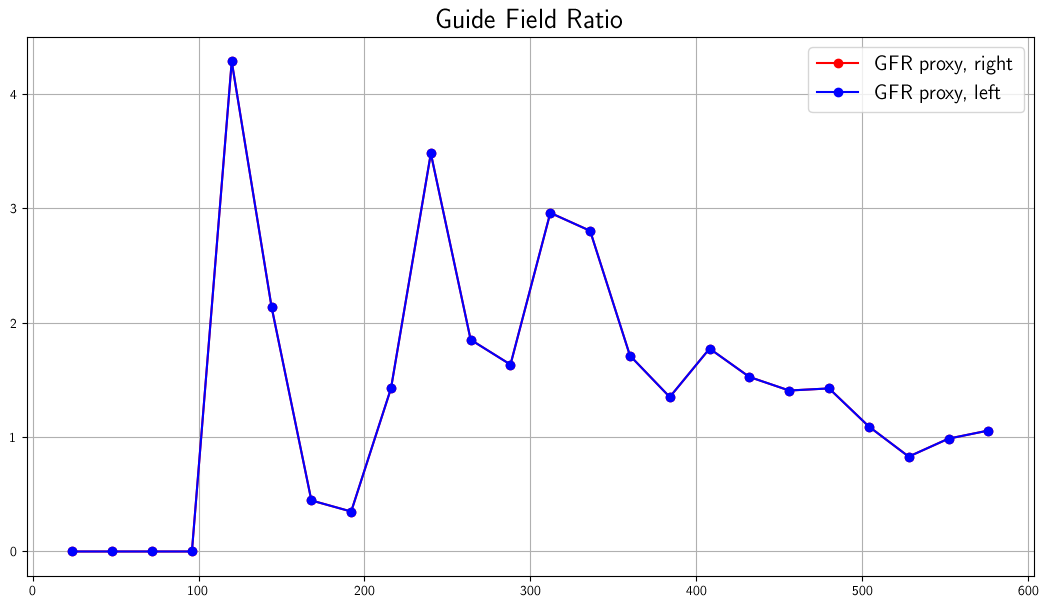

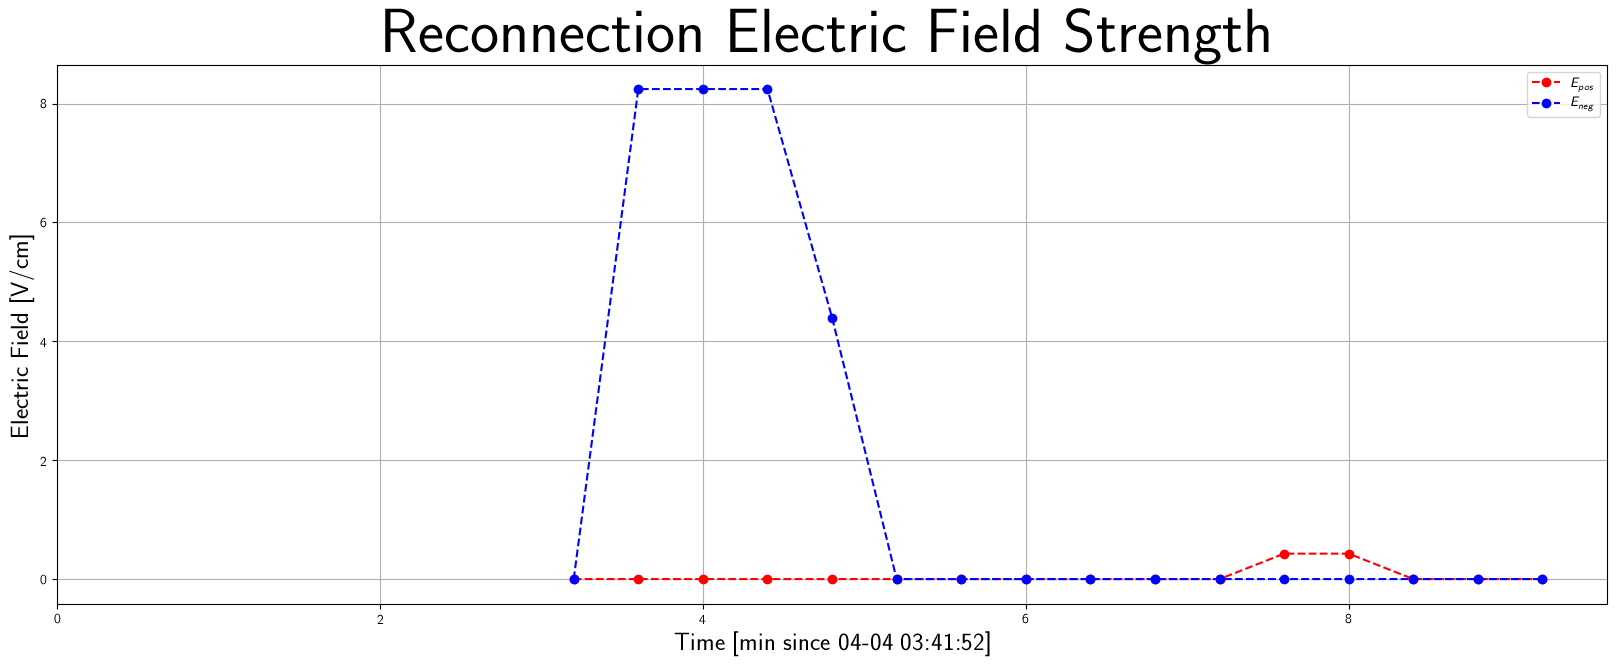

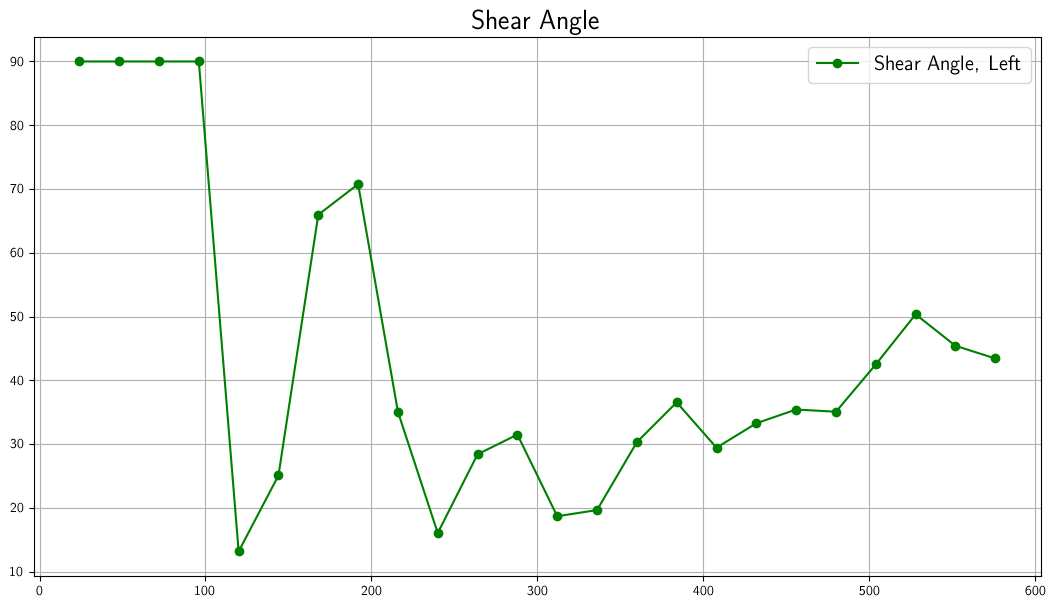

In [130]:
gfr = fl_funcs.gfrcalc_alt(guide, distneg_med, distpos_med)

print("Plot guide field ratio proxy based on footpoints.")

# Plot guide field ratio
fl_funcs.plt_gfr(times, gfr, gfr, flnum, dt1600)

print("Fermi Processing")

raw_hxr_sum, cspec_hxr_sum, fermitimes = fl_funcs.process_fermi(daystr, mostr,
                                                                yearstr,
                                                                instrument,
                                                                day, mo, year,
                                                                low=3500,
                                                                high=4500,
                                                                ylo=1e-3,
                                                                yhi=100)

# Figure for timestamp comparison

indstrt_sep = 1
indstrt_elon = 1
gfr_trans = 8

E_pos, E_neg, E_rat, time_E = fl_funcs.E_field_det(conv_f, distpos_med,
                                                   distneg_med, timelab,
                                                   hmi_dat, pos_rem, neg_rem,
                                                   flnum, dt1600, times,
                                                   startind=gfr_trans)

E_pos = np.append(E_pos, E_pos[-1])
E_neg = np.append(E_neg, E_neg[-1])

shear_ang = fl_funcs.shear_to_angle(times, flnum, dt1600, gfr, gfr)

quartermaxtim = fl_funcs.quartermaxtime(
    gfr_trans, gfr, gfr, timelab, fl_funcs.find_nearest_ind, flag=0)

print(quartermaxtim)

In [29]:
import importlib


In [83]:
fermi = cspec_hxr_sum[low_hxr:high_hxr,0]/275.0
minfermi = min(fermi)
maxfermi = max(fermi)

normfermi = (fermi - minfermi)/(maxfermi-minfermi)

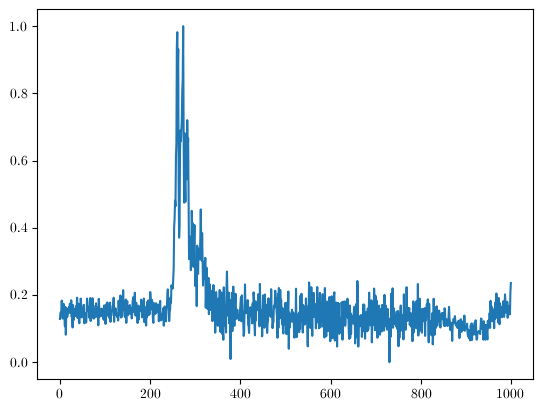

In [84]:
plt.plot(normfermi)

In [127]:
importlib.reload(fl_funcs)

<module 'fl_funcs' from '/Users/coletamburri/Desktop/flare_imp_study/fl_funcs.py'>

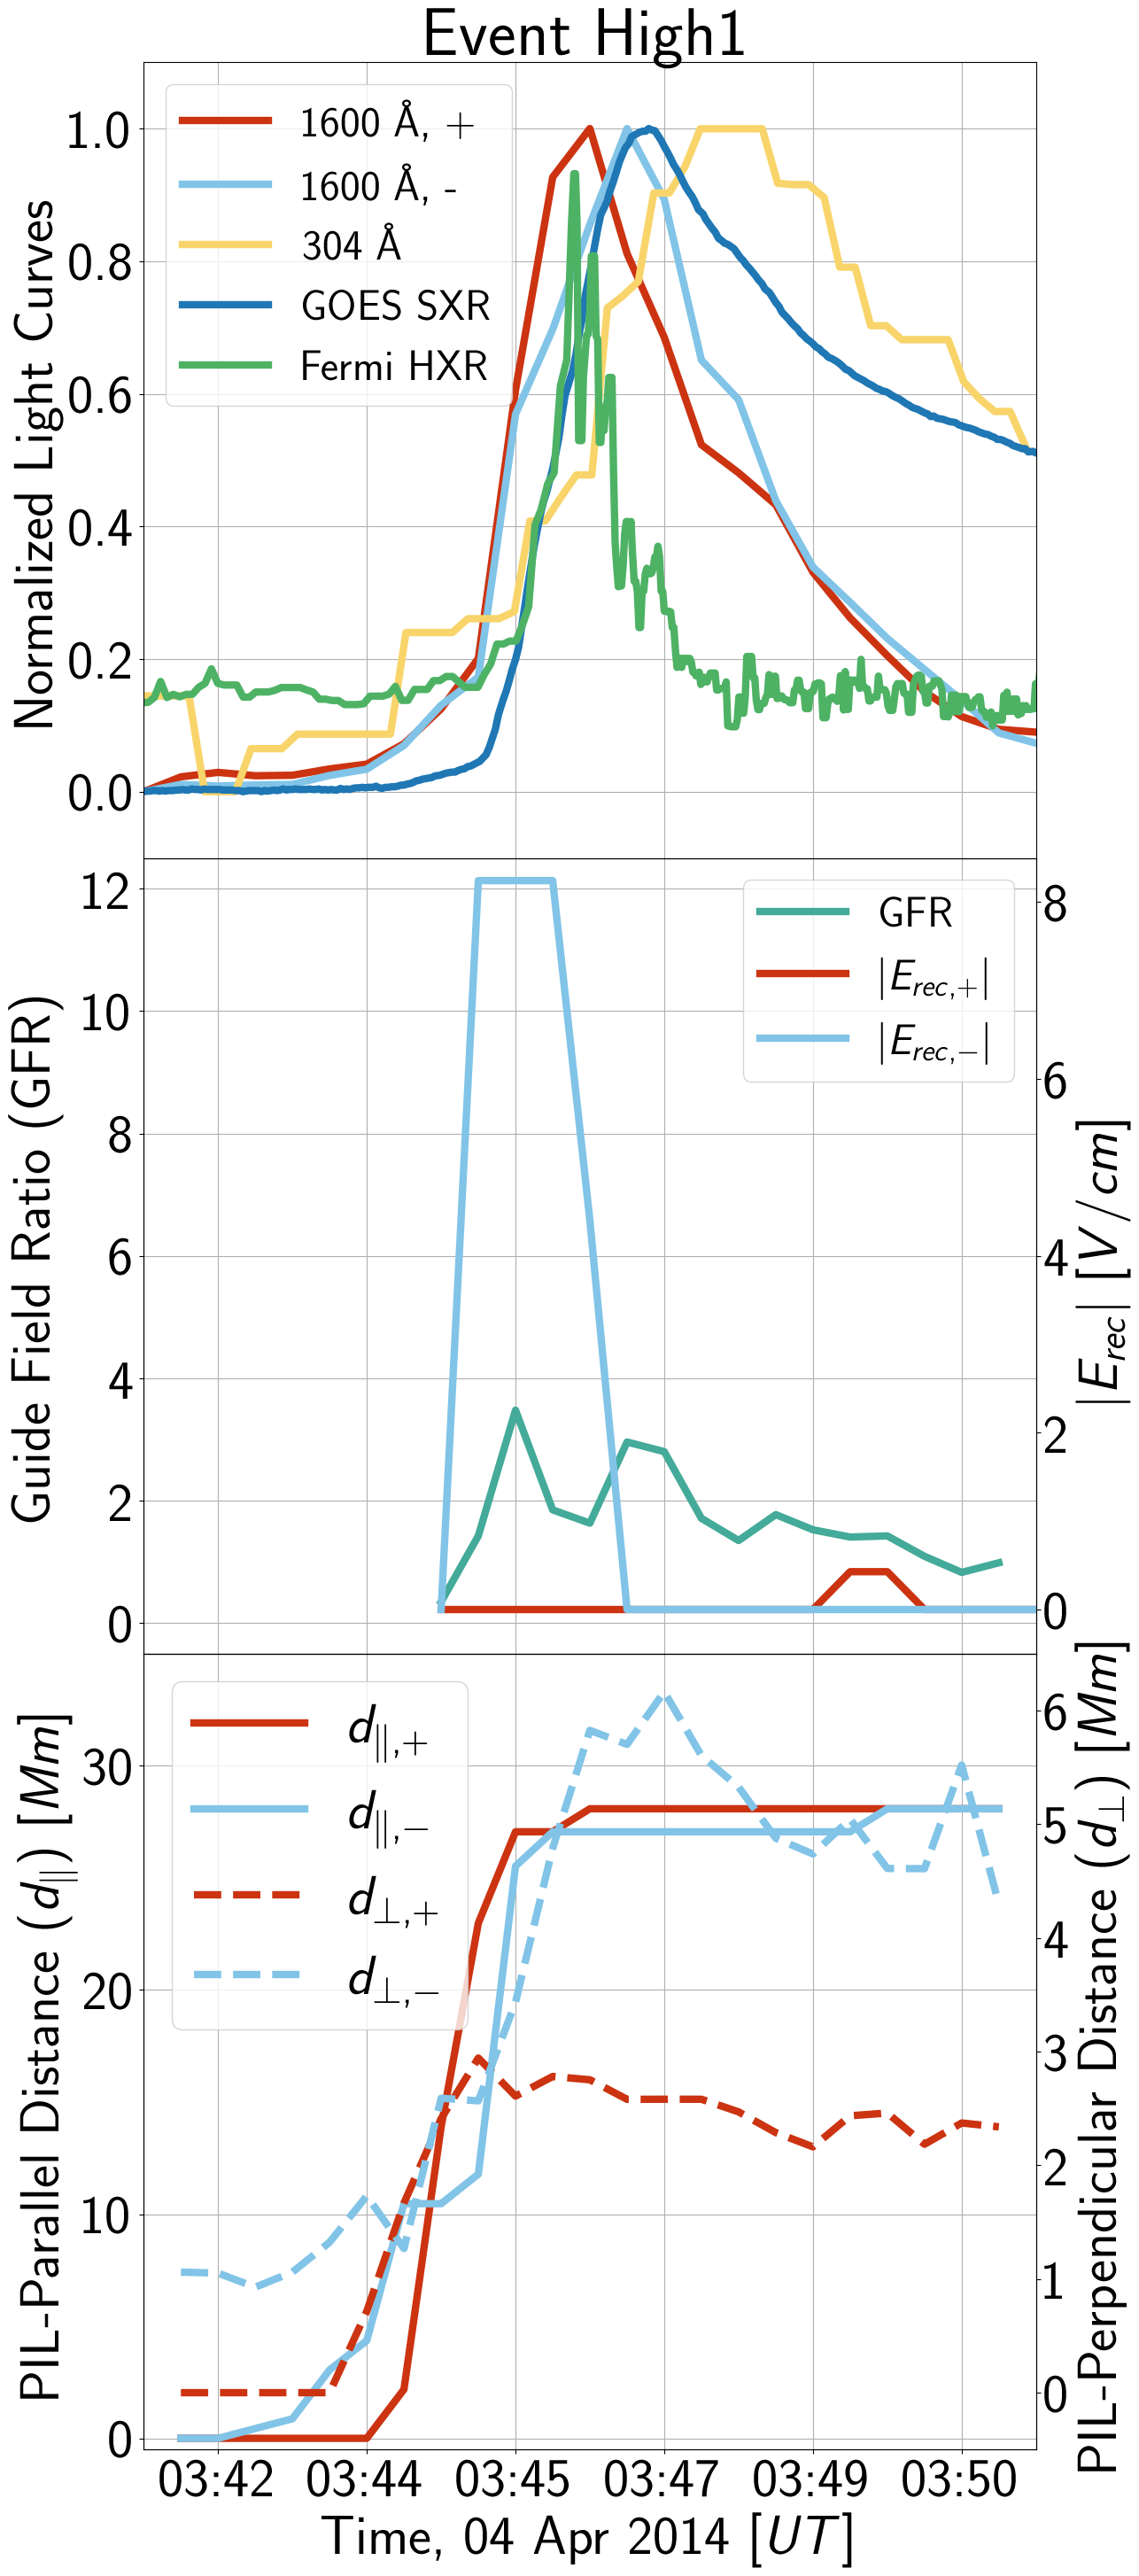

In [128]:
muted = fl_funcs.color_muted()
vibrant = fl_funcs.color_vibrant()
medc = fl_funcs.color_medc()
level = 'high'
sxr_fn='/Users/coletamburri/Desktop/sci_gxrs-l2-irrad_g15_d20140404_v0-0-0.nc'

fl_funcs.plt_fourpanel(times, gfr, gfr, flnum, dt1600, time304,
                       filter_304, lens_pos_Mm, lens_neg_Mm, distpos_Mm,
                       distneg_Mm, dt304, timelab, conv_f,
                       elonperiod_start_pos, elonperiod_end_pos,
                       elonperiod_start_neg, elonperiod_end_neg,
                       sepperiod_start_pos, sepperiod_end_pos,
                       sepperiod_start_neg, sepperiod_end_neg, exp_ind,
                       s304, e304, pos1600, neg1600, dn1600, indstrt_elon,
                       indstrt_sep, fermitimes, raw_hxr_sum, cspec_hxr_sum,
                       gfr_trans, E_pos, E_neg, time_E, daystr,mostrcap,yearstr,
                       xcl,xclnum,imp, muted, vibrant, medc,sxr_fn,level,low_hxr=3500, high_hxr=4500,
                       period_flag=0, tick_space=4,fermioff=0,fllab='High1')